# Heterogenous treatment effect models
Julian Hsu
30 Aug 2021

### Table of Contents with Navigation Links
* [Write ML Models](#Section1)
* [Simulator Functions](#Section2)
* [Many Simulations](#Section3)

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import os as os 
import scipy.stats 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
from IPython.display import display    

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso, LassoCV, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error

import warnings



In [2]:
print(os.getcwd())
import stnomics as st

/Users/hsujulia/Documents/GitHub/statanomics/causalmodels


In [3]:
def gen_data_hte(N, hte_type):
    '''
    Generate data with different types of HTE forms:
    '''
    
    df = pd.DataFrame()
    x = np.random.uniform(0,1, N)
    y = 10 + 2*(np.log(1+x)) + x**2 + np.random.normal(0,1,N)
    
    if hte_type=='constant':
        hte = 1
    elif hte_type=='linear':
        hte = 2*x
    elif hte_type=='quadratic':
        hte = 0.5*x**2
    elif hte_type=='piecewise':
        hte = np.zeros_like(x)
        hte[(x < 0.20)] = 1
        hte[(x >=0.20) & (x < 0.80) ] = 2
        hte[(x >=0.80) ] = 5
    elif hte_type=='log':
        hte = np.log(1+x*2)*1.5
    elif hte_type=='piecewise_linear':
        hte = np.zeros_like(x)
        hte[(x < 0.20)] = x[(x < 0.20)]*0.1
        hte[(x >=0.20) & (x < 0.80) ] = x[(x >=0.20) & (x < 0.80) ]*0.75
        hte[(x >=0.80) ] = x[(x >=0.80) ]*(-0.5)
    elif hte_type=='trig':
        hte = np.sin(1+x*10)*x
    else:
        print('Choose a hte type!')
        
    t = ( np.exp(x) / (1+np.exp(x)) > np.random.uniform(0,1,N)).astype(float)
    y  += t*hte
    return pd.DataFrame(data={'x':x, 't':t, 'y':y, 'hte': hte})

In [4]:
model_max_iter = 5000
## treatment prediction models
t_models = {}
t_models['LogitCV'] = LogisticRegressionCV(cv=5, random_state=27, n_jobs=-1)
t_models['logit'] = LogisticRegression(penalty='l2',solver='lbfgs', C=1, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L1_C2'] = LogisticRegression(penalty='l1',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L2_C5'] = LogisticRegression(penalty='l2',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['rf_md10'] = RandomForestClassifier(n_estimators=25,max_depth=10, min_samples_split=200,n_jobs=-1)
t_models['rf_md3'] = RandomForestClassifier(n_estimators=25,max_depth=3, min_samples_split=200,n_jobs=-1)
t_models['nn'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1,max_iter=model_max_iter)
## outcome prediction models
y_models = {}
y_models['LassoCV'] = LassoCV(cv=5, n_jobs=-1, normalize=True, random_state=27)
y_models['ols'] = LinearRegression()
y_models['lasso_a2'] = Lasso(alpha=2,max_iter=model_max_iter)
y_models['ridge_a2'] = Ridge(alpha=2,max_iter=model_max_iter)
y_models['rf_md10'] = RandomForestRegressor(n_estimators=25,max_depth=10, min_samples_split=200,n_jobs=-1)
y_models['rf_md3'] = RandomForestRegressor(n_estimators=25,max_depth=3, min_samples_split=200,n_jobs=-1)
y_models['nn'] = MLPRegressor(alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1, max_iter=model_max_iter)

In [5]:
aux_dictionary = {'force_second_stage':'CVLasso'}
n_data_splits = 5
lasso_max_iter = 5000
lasso_alpha = 5

# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.901467085891454, tolerance: 0.8087134560719147
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.305124216153672, tolerance: 0.8087134560719147
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.885567675883067, tolerance: 0.877639761831045
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: 

<ipython-input-6-fb50426e5489>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1874852385517443, tolerance: 0.8974665817390262
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.412338381729569, tolerance: 0.9288010724096488
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9031530663567082, tolerance: 0.20214429290130265
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9366536005270518, tolerance: 0.20214429290130265
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3940449188137336, tolerance: 0.20214429290130265
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.p

<ipython-input-6-fb50426e5489>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1897803079564255, tolerance: 0.5425691704119238
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.508048541550579, tolerance: 0.5425691704119238
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5813193906528795, tolerance: 0.2000674994921437
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40493636607197914, tolerance: 0.20041141637023607
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5011171855467182, tolerance: 0.2000674994921437
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9812098715838147, tolerance: 0.21301254994015104
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8786751614497916, tolerance: 0.21463710912095812
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.07190295113719, tolerance: 0.21301254994015104
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.045508583634728, tolerance: 0.9637753049807173
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3772023335131962, tolerance: 0.967729075236318
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.271094866830026, tolerance: 0.9637753049807173
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633:

<ipython-input-6-fb50426e5489>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


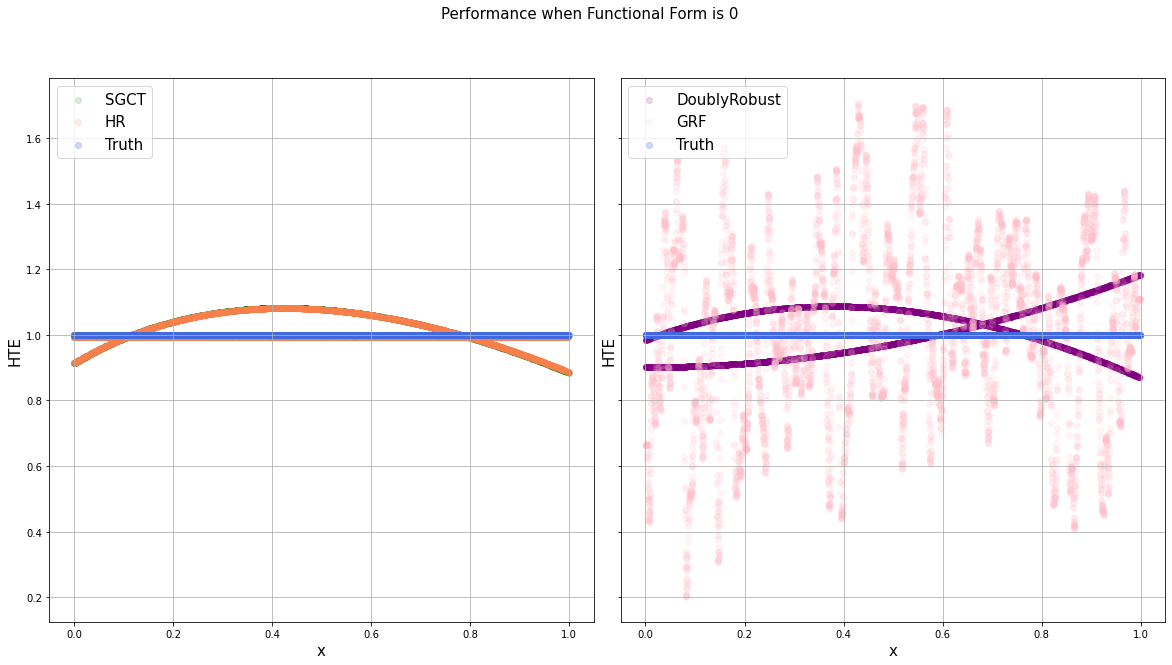

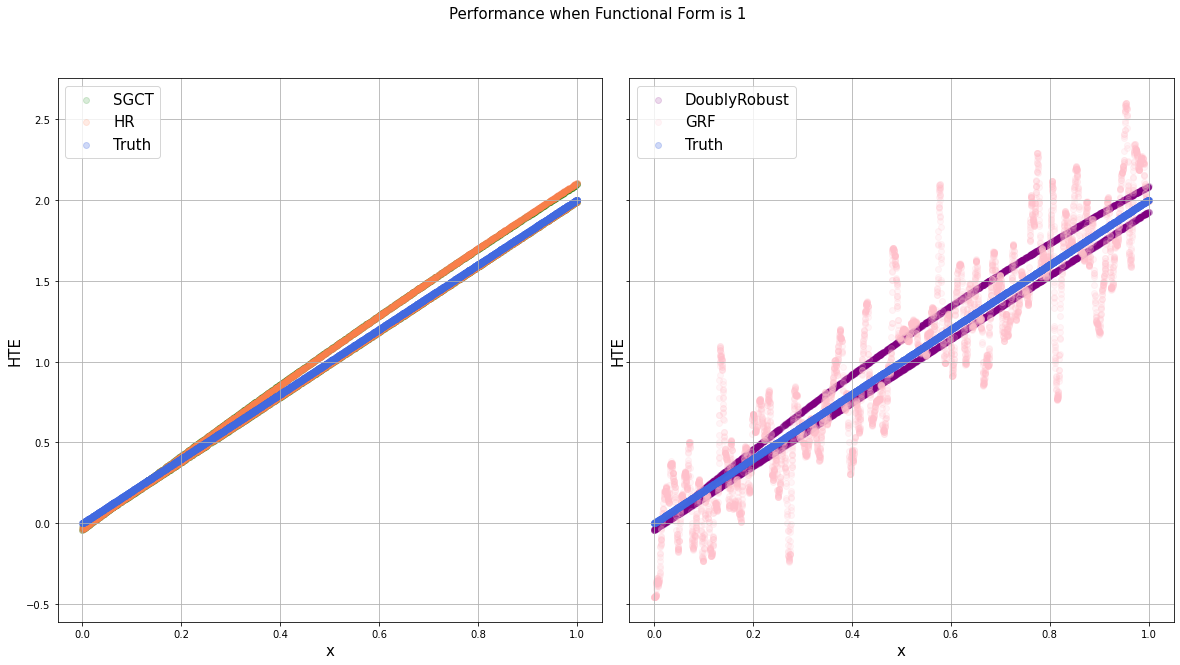

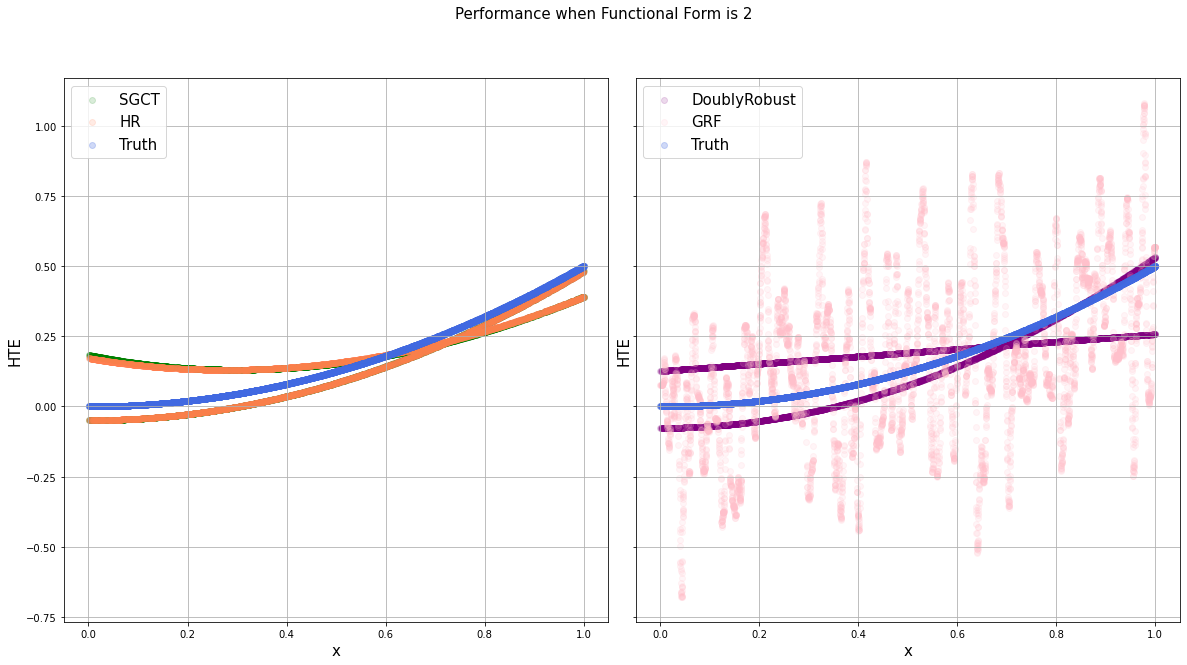

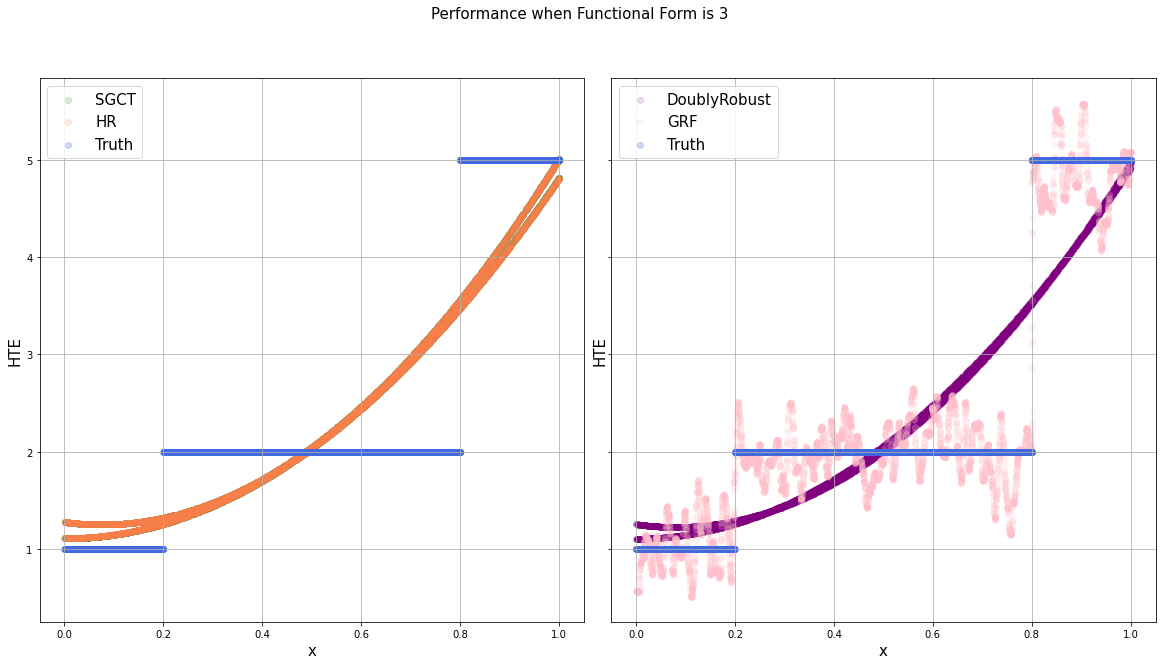

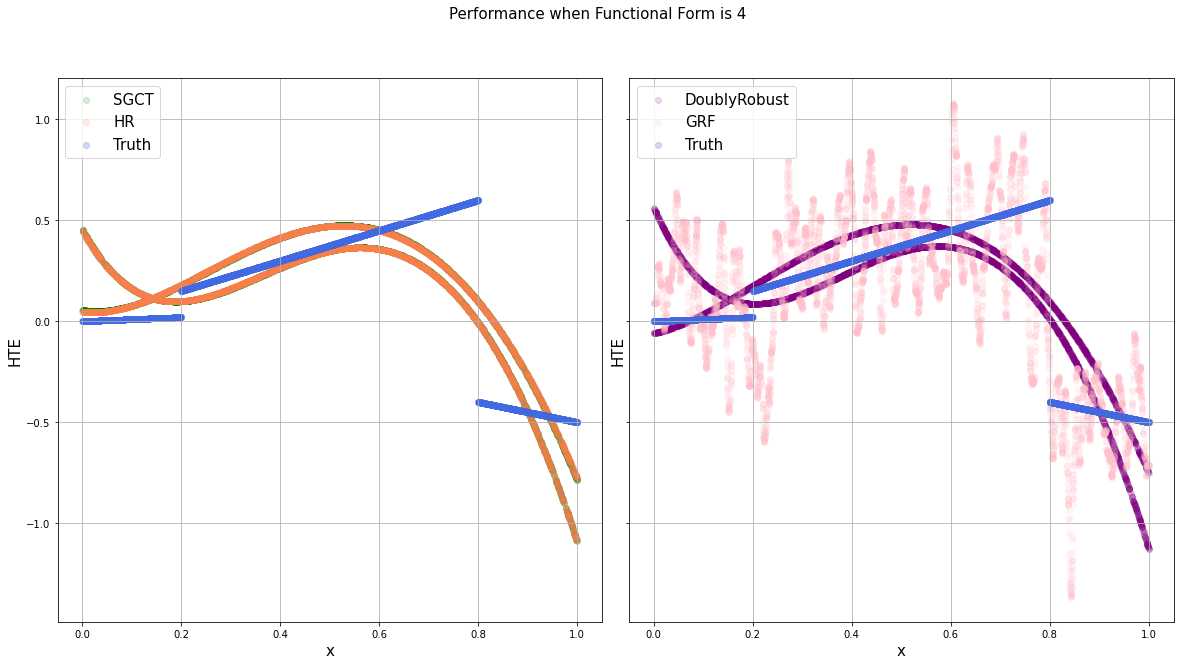

In [6]:
N = 5000
i = 0
for t in ['constant','linear','quadratic','piecewise','piecewise_linear']:

    df = gen_data_hte(N, t)
    
    df['x2'] = df['x'].pow(2)
    df['x2_ln'] = np.log(1+df['x'])    
#     for p in range(9):
#         df['x_'+str(p)] = ( np.round(df['x'],1)==np.round(p*0.1,1) ).astype(float)
#         df['x_X'+str(p)] = df['x_'+str(p)]*df['x']
    full_feature_list = [ x for x in df.columns if 'x' in x]

    ## 3. Run through each combination of models
    SGCT = st.hte.het_dml_approaches.SGCT(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, aux_dictionary)
    df['dml_SGCT_TE'] = SGCT[0]
    df['dml_SGCT_SE'] = SGCT[1]    
    df['dml_SGCT_P'] = SGCT[2]
    df['dml_SGCT_Y0'] = SGCT[3]        

    HR = st.hte.het_dml_approaches.HR(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, aux_dictionary)
    df['dml_HR_TE'] = HR[0]
    df['dml_HR_SE'] = HR[1]    
    df['dml_HR_P'] = HR[2]
    df['dml_HR_Y0'] = HR[3]

    dr_cvl = st.hte.other.DR(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, {'force_second_stage':'CVLasso'})
    df['DR_CVL_TE'] = dr_cvl[0]
    df['DR_CVL_SE'] = dr_cvl[1]   
    df['DR_CVL_P'] = dr_cvl[2]
    df['DR_CVL_Y0'] = dr_cvl[3]


    tree_grf = st.hte.trees.grf(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, {'n_estimators':1000})
    df['GRF_TE'] = tree_grf[0]
    df['GRF_SE'] = tree_grf[1]
    df['GRF_P'] = tree_grf[2]
    df['GRF_Y0'] = tree_grf[3]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10),sharex=True, sharey=True)

    ax[0].scatter(df['x'], df['dml_SGCT_TE'], label='SGCT', alpha = 0.15, color='green')
    ax[0].scatter(df['x'], df['dml_HR_TE'], label='HR', alpha = 0.15, color='coral')
    ax[0].scatter(df['x'], df['hte'], label='Truth', alpha = 0.25, color='royalblue')

    ax[0].legend(loc='upper left', fontsize=15)
    ax[0].grid()
    ax[0].set_ylabel('HTE', fontsize=15)
    ax[0].set_xlabel('x', fontsize=15)
    
    ax[1].scatter(df['x'], df['DR_CVL_TE'], label='DoublyRobust', alpha = 0.15, color='purple')
    ax[1].scatter(df['x'], df['GRF_TE'], label='GRF', alpha = 0.15, color='pink')
    ax[1].scatter(df['x'], df['hte'], label='Truth', alpha = 0.25, color='royalblue')
    
    ax[1].legend(loc='upper left', fontsize=15)
    ax[1].grid()
    ax[1].set_ylabel('HTE', fontsize=15)
    ax[1].set_xlabel('x', fontsize=15)
    fig.subplots_adjust(wspace=0.05, hspace=0)
    fig.suptitle('Performance when Functional Form is {0}'.format(i), fontsize=15) 
    fig.patch.set_facecolor('white')
    fig.show()
    i+=1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.944216577194311, tolerance: 0.8771182211479908
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.337672904966894, tolerance: 0.8629770593753158
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9690683080243616, tolerance: 0.8802694994053858
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633

<ipython-input-8-fabeb58735fc>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34292804794085896, tolerance: 0.24948233461246164
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2944360577232601, tolerance: 0.25429609580127804
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

<ipython-input-8-fabeb58735fc>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3496739546249046, tolerance: 0.20520763186907262
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6206265174680539, tolerance: 0.20520763186907262
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3153647165468101, tolerance: 0.21320420396845927
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5173848538522634, tolerance: 0.20520763186907262
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.974092038914705, tolerance: 0.20520763186907262
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8691141997369414, tolerance: 0.9279609375661878
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.630407788643424, tolerance: 0.9279609375661878
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8900094565015024, tolerance: 0.9509053919452006
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:63

<ipython-input-8-fabeb58735fc>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.704e-01, tolerance: 6.637e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.704e-01, tolerance: 6.637e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarnin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e+03, tolerance: 1.586e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e+03, tolerance: 1.586e+00
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-fabeb58735fc>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarnin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+02, tolerance: 2.507e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+02, tolerance: 2.507e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27393101319239577, tolerance: 0.2143650734826631
  model = cd_fast.enet_coordinate_desce

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e+02, tolerance: 2.507e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e+02, tolerance: 2.507e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3763442782910715, tolerance: 0.9413069305054129
  model = cd_fast.enet_coordinate_descen

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.2636744307556, tolerance: 0.8692418047048963
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.62824810071652, tolerance: 0.9028598575945704
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.265536320691353, tolerance: 0.8497476770095124
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633:

<ipython-input-8-fabeb58735fc>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


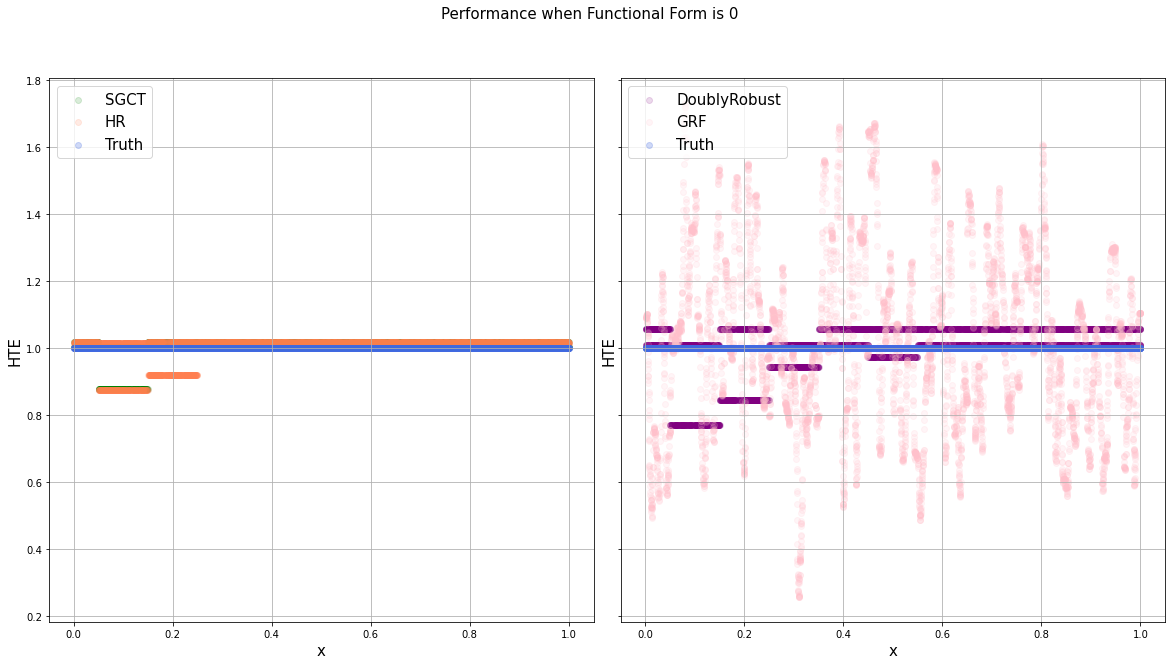

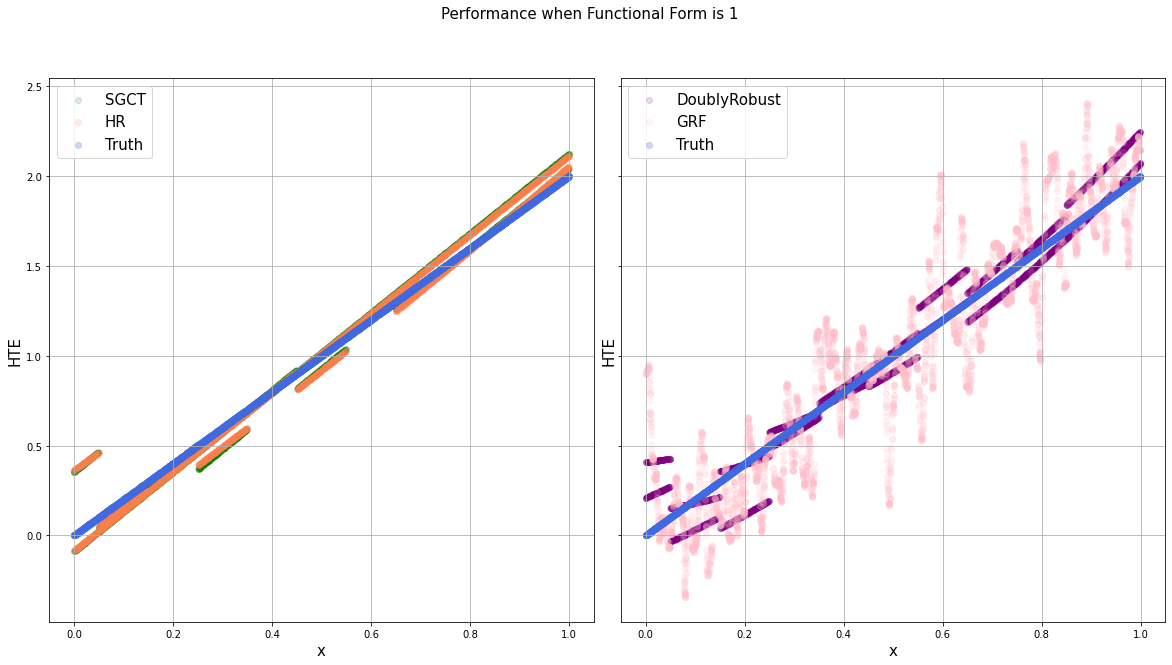

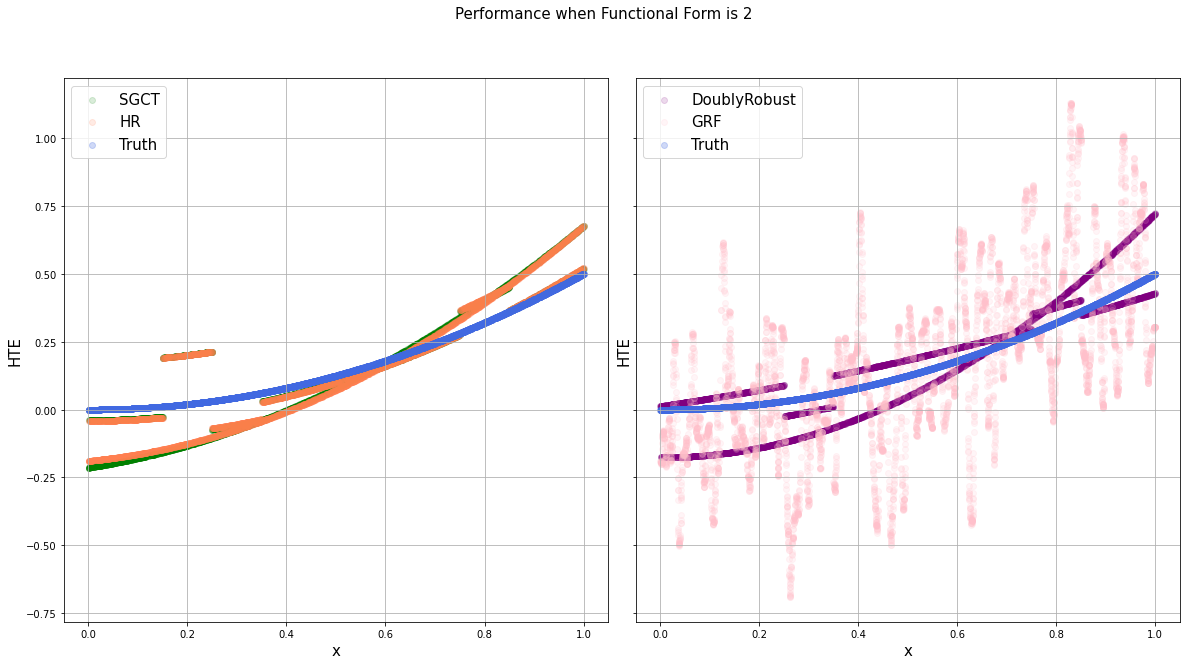

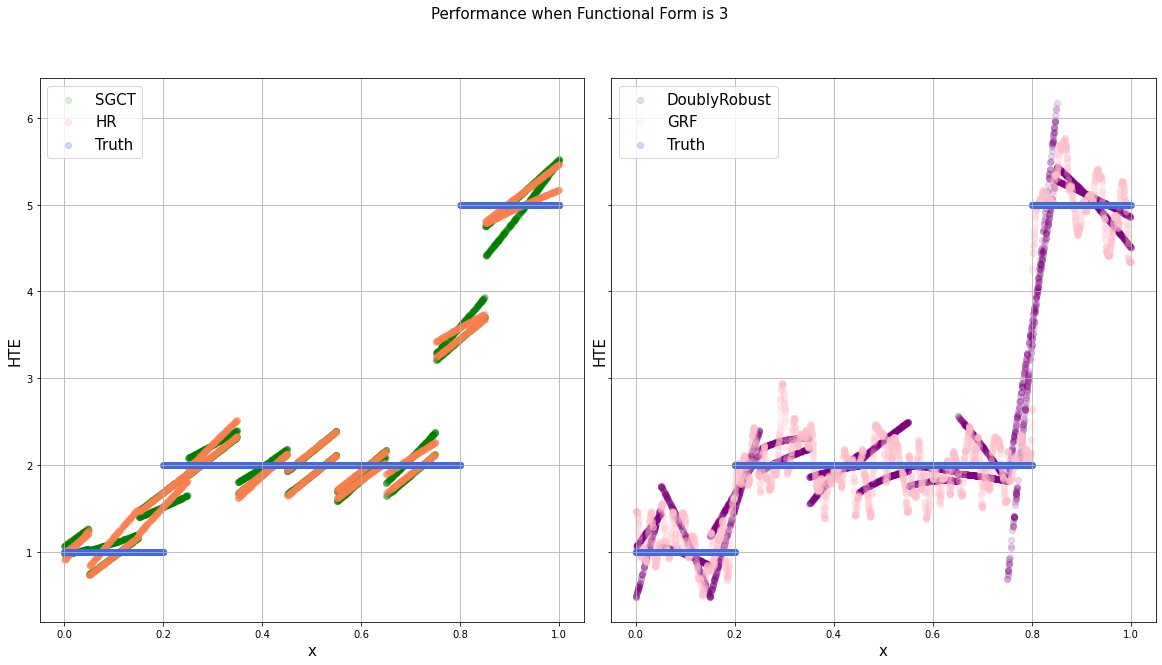

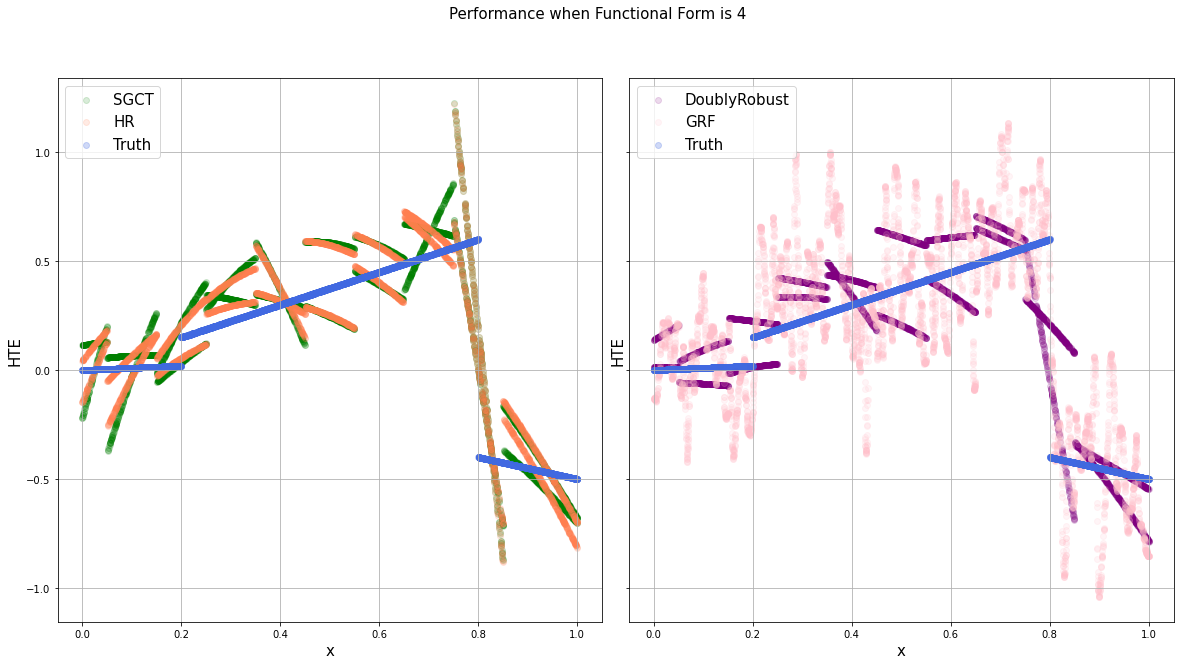

In [8]:
N = 5000
i = 0
for t in ['constant','linear','quadratic','piecewise','piecewise_linear']:

    df = gen_data_hte(N, t)
    
    df['x2'] = df['x'].pow(2)
    df['x2_ln'] = np.log(1+df['x'])
    for p in range(9):
        df['x_'+str(p)] = ( np.round(df['x'],1)==np.round(p*0.1,1) ).astype(float)
        df['x_X'+str(p)] = df['x_'+str(p)]*df['x']
    full_feature_list = [ x for x in df.columns if 'x' in x]

    
    SGCT = st.hte.het_dml_approaches.SGCT(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, aux_dictionary)
    df['dml_SGCT_TE'] = SGCT[0]
    df['dml_SGCT_SE'] = SGCT[1]    
    df['dml_SGCT_P'] = SGCT[2]
    df['dml_SGCT_Y0'] = SGCT[3]        

    HR = st.hte.het_dml_approaches.HR(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, aux_dictionary)
    df['dml_HR_TE'] = HR[0]
    df['dml_HR_SE'] = HR[1]    
    df['dml_HR_P'] = HR[2]
    df['dml_HR_Y0'] = HR[3]

    dr_cvl = st.hte.other.DR(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, {'force_second_stage':'CVLasso'})
    df['DR_CVL_TE'] = dr_cvl[0]
    df['DR_CVL_SE'] = dr_cvl[1]   
    df['DR_CVL_P'] = dr_cvl[2]
    df['DR_CVL_Y0'] = dr_cvl[3]


    tree_grf = st.hte.trees.grf(df, 
                    full_feature_list, 'y', 't',
                    full_feature_list,
                    y_models['ols'], t_models['logit'],
                   n_data_splits, {'n_estimators':1000})
    df['GRF_TE'] = tree_grf[0]
    df['GRF_SE'] = tree_grf[1]
    df['GRF_P'] = tree_grf[2]
    df['GRF_Y0'] = tree_grf[3]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10),sharex=True, sharey=True)

    ax[0].scatter(df['x'], df['dml_SGCT_TE'], label='SGCT', alpha = 0.15, color='green')
    ax[0].scatter(df['x'], df['dml_HR_TE'], label='HR', alpha = 0.15, color='coral')
    ax[0].scatter(df['x'], df['hte'], label='Truth', alpha = 0.25, color='royalblue')

    ax[0].legend(loc='upper left', fontsize=15)
    ax[0].grid()
    ax[0].set_ylabel('HTE', fontsize=15)
    ax[0].set_xlabel('x', fontsize=15)
    
    ax[1].scatter(df['x'], df['DR_CVL_TE'], label='DoublyRobust', alpha = 0.15, color='purple')
    ax[1].scatter(df['x'], df['GRF_TE'], label='GRF', alpha = 0.15, color='pink')
    ax[1].scatter(df['x'], df['hte'], label='Truth', alpha = 0.25, color='royalblue')
    
    ax[1].legend(loc='upper left', fontsize=15)
    ax[1].grid()
    ax[1].set_ylabel('HTE', fontsize=15)
    ax[1].set_xlabel('x', fontsize=15)
    fig.subplots_adjust(wspace=0.05, hspace=0)
    fig.suptitle('Performance when Functional Form is {0}'.format(i), fontsize=15) 
    fig.patch.set_facecolor('white')
    fig.show()
    i+=1